In [57]:
# Residual Network for batch effect correction
# See more at: https://github.com/ushaham/BatchEffectRemoval
# Hoa Tran
# Update code from python version 2 to python version 3, Keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import time
from datetime import timedelta
import scanpy as sc
from Calibration_Util import utils_resnet as utils     # our func
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4+18.gaabe446 anndata==0.6.17 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [58]:
# Create folder to save the results 
import os
dirname = os.getcwd()
print(dirname)
data_dir = os.path.join('/home/hoa/hoatran/demo_normalization/dataset/dataset4_human_pancreatic/filter_data_Hoa/')
# if not os.path.exists('./results_cellatlas/'): os.makedirs('./results_cellatlas/')

if not os.path.exists('./results/'): os.makedirs('./results/')   
if not os.path.exists('./results/results_dataset4_pancreatic/'): os.makedirs('./results/results_dataset4_pancreatic/')    
save_dir = os.path.join(dirname, 'results/results_dataset4_pancreatic/')

# Function to save figure as image in the figures folder
save_fig_dir='./figures/dataset4_pancreatic/'
if not os.path.exists('./figures/'): os.makedirs('./figures/')
if not os.path.exists(save_fig_dir): os.makedirs(save_fig_dir)
def save_images(filename, save_fig_dir):    
    outname = save_fig_dir + filename + '.png'
    pl.savefig(outname, dpi=150)
    pl.close()

/acrc/jinmiao/CJM_lab/hoatran/demo_normalization/demo_ResNet/resnet


In [60]:
myDataFn = 'myData_pancreatic_5batches.txt'
mySampleFn = 'mySample_pancreatic_5batches.txt'
savefn = 'myRawData1.h5ad'
adata = utils.load_data(data_dir, myDataFn, mySampleFn, save_dir, savefn,saveh5ad=True)

In [62]:
print('Read and filter data')
savefn = 'myRawData1.h5ad'
adata = sc.read_h5ad(os.path.join(save_dir,savefn))


Read and filter data


In [68]:
# Ignore this step for this dataset
# Filtering data 
adata
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.log1p(adata)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata

AnnData object with n_obs × n_vars = 14767 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'

In [69]:
# Here authors extract 50 pca vectors to train the network model
npcs_train = 50  
sc.tl.pca(adata, svd_solver='arpack', n_comps=npcs_train)  # output save to adata.obsm['X_pca']

# Raw data visualization
utils.get_tsne_umap_raw(adata, perplex=30, npcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:10.60) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing tSNE
    using 'X_pca' with n_pcs = 20
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:01:44.96) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP
    finished (0:00:19.02) --> added
    'X_umap', UMAP coordinates (adata.obsm)


AnnData object with n_obs × n_vars = 14767 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'batchlb_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [70]:
# Extract data from batch 1 and batch 2
adata1_filtered = adata[adata.obs['batch']==1,:].copy()  # after concatenate, the values change from 1 to 0, 2 to 1
print(adata1_filtered)
adata2_filtered = adata[adata.obs['batch']==2,:].copy()
print(adata2_filtered)
adata3_filtered = adata[adata.obs['batch']==3,:].copy()
print(adata3_filtered)
adata4_filtered = adata[adata.obs['batch']==4,:].copy()
print(adata4_filtered)
adata5_filtered = adata[adata.obs['batch']==5,:].copy()
print(adata5_filtered)
adata1_filtered.obsm['X_pca'] *= -1 # multiply by -1 to match Seurat, as suggestion from Scanpy
adata2_filtered.obsm['X_pca'] *= -1 # multiply by -1 to match Seurat, as suggestion from Scanpy
adata3_filtered.obsm['X_pca'] *= -1 # multiply by -1 to match Seurat, as suggestion from Scanpy
adata4_filtered.obsm['X_pca'] *= -1 # multiply by -1 to match Seurat, as suggestion from Scanpy
adata5_filtered.obsm['X_pca'] *= -1 # multiply by -1 to match Seurat, as suggestion from Scanpy
print(adata2_filtered.obsm['X_pca'].shape[1])

AnnData object with n_obs × n_vars = 8569 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'batchlb_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 2122 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'batchlb_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 2127 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'batchlb_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 457 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'batchlb_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
 

In [71]:
import keras.optimizers
from keras.layers import Input, Dense, merge, BatchNormalization, Activation
from keras.models import Model
from keras import callbacks as cb
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
import math
from keras import backend as K
import sklearn.preprocessing as prep
from sklearn import decomposition
from statsmodels.distributions.empirical_distribution import ECDF
from keras import initializers
from keras.layers import add
from Calibration_Util import CostFunctions as cf  # author func
from Calibration_Util import Monitoring as mn     # author func



In [72]:
target1 = adata1_filtered.obsm['X_pca']
source2 = adata2_filtered.obsm['X_pca']
source3 = adata3_filtered.obsm['X_pca']
source4 = adata4_filtered.obsm['X_pca']
source5 = adata5_filtered.obsm['X_pca']
space_dim = 50
batch_size = 50
penalty = 1e-2
nbeps = 20
val_split = 0.1


Create a training model: 
setting scales using KNN
[21.638855003373244, 43.27771000674649, 86.55542001349298]
setting all scale weights to 1


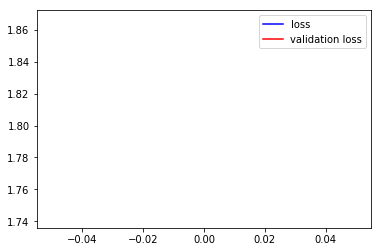

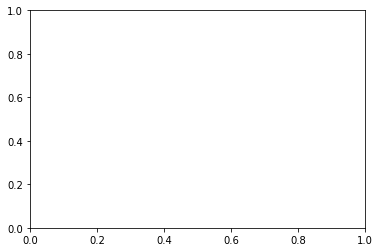

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

(2122, 50)
Took 0:05:00.136907


In [73]:
savedfl2 = 'resnet_d4_target1_source2'
t21 = time.time()
calibMMDNet2,block2_output2 = utils.createMMDResNetModel(target1, source2, space_dim, batch_size, penalty, 
                                                   save_dir, nbeps, val_split, savedfl2)
afterCalib2 = calibMMDNet2.predict(source2)   # align, calibrate source data to target data
print(afterCalib2.shape)
t22 = time.time()
print('Took '+str(timedelta(seconds=t22-t21)))

Create a training model: 
setting scales using KNN
[21.708966851537845, 43.41793370307569, 86.83586740615138]
setting all scale weights to 1


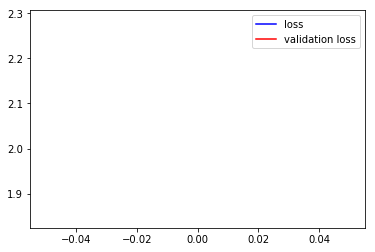

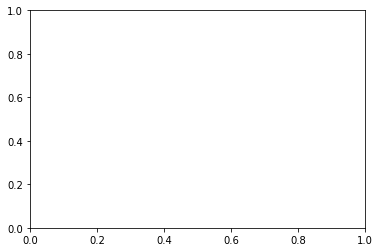

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

(2127, 50)
Took 0:04:47.098988


In [74]:
savedfl3 = 'resnet_d4_target1_source3'
t31 = time.time()
calibMMDNet3,block2_output3 = utils.createMMDResNetModel(target1, source3, space_dim, batch_size, penalty, 
                                                   save_dir, nbeps, val_split, savedfl3)
afterCalib3 = calibMMDNet3.predict(source3)   # align, calibrate source data to target data
print(afterCalib3.shape)
t32 = time.time()
print('Took '+str(timedelta(seconds=t32-t31)))

Create a training model: 
setting scales using KNN
[21.577988963669334, 43.15597792733867, 86.31195585467734]
setting all scale weights to 1


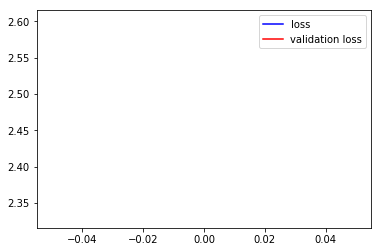

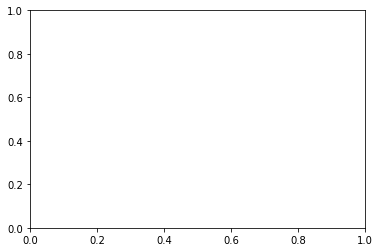

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

(457, 50)
Took 0:01:54.367792


In [75]:
savedfl4 = 'resnet_d4_target1_source4'
t41 = time.time()
calibMMDNet4,block2_output4 = utils.createMMDResNetModel(target1, source4, space_dim, batch_size, penalty, 
                                                   save_dir, nbeps, val_split, savedfl4)
afterCalib4 = calibMMDNet4.predict(source4)   # align, calibrate source data to target data
print(afterCalib4.shape)
t42 = time.time()
print('Took '+str(timedelta(seconds=t42-t41)))

Create a training model: 
setting scales using KNN
[21.617269499803633, 43.23453899960727, 86.46907799921453]
setting all scale weights to 1


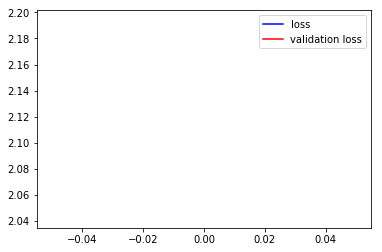

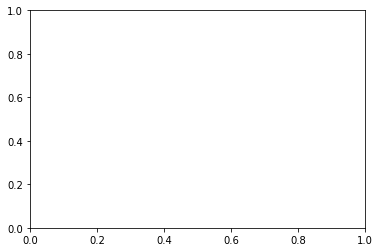

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

(1492, 50)
Took 0:03:51.425795


In [76]:
savedfl5 = 'resnet_d4_target1_source5'
t51 = time.time()
calibMMDNet5,block2_output5 = createMMDResNetModel(target1, source5, space_dim, batch_size, penalty, 
                                                   save_dir, nbeps, val_split, savedfl5)
afterCalib5 = calibMMDNet5.predict(source5)   # align, calibrate source data to target data
print(afterCalib5.shape)
t52 = time.time()
print('Took '+str(timedelta(seconds=t52-t51)))

In [77]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
# Plot distribution, see the change after train and predict source data, compared to target data
# from Calibration_Util import ScatterDemo as sd

save_file_bf2 = os.path.join(save_fig_dir,'d12_distribution_before_target1_source2.png')
save_file_af2 = os.path.join(save_fig_dir, 'd12_distribution_after_target1_source2.png')

save_file_bf3 = os.path.join(save_fig_dir,'d12_distribution_before_target1_source3.png')
save_file_af3 = os.path.join(save_fig_dir, 'd12_distribution_after_target1_source3.png')

save_file_bf4 = os.path.join(save_fig_dir,'d12_distribution_before_target1_source4.png')
save_file_af4 = os.path.join(save_fig_dir, 'd12_distribution_after_target1_source4.png')

save_file_bf5 = os.path.join(save_fig_dir,'d12_distribution_before_target1_source5.png')
save_file_af5 = os.path.join(save_fig_dir, 'd12_distribution_after_target1_source5.png')

# The PCs most correlated with the batch are {1 and 2} or {3 and 5}
pc1 = 0
pc2 = 1
utils.myScatterHistDemo(target1[:,pc1], target1[:,pc2], source2[:,pc1], source2[:,pc2],save_file_bf2)
utils.myScatterHistDemo(target1[:,pc1], target1[:,pc2], afterCalib2[:,pc1], afterCalib2[:,pc2],save_file_af2)
utils.myScatterHistDemo(target1[:,pc1], target1[:,pc2], source3[:,pc1], source3[:,pc2],save_file_bf3)
utils.myScatterHistDemo(target1[:,pc1], target1[:,pc2], afterCalib3[:,pc1], afterCalib3[:,pc2],save_file_af3)
utils.myScatterHistDemo(target1[:,pc1], target1[:,pc2], source4[:,pc1], source4[:,pc2],save_file_bf4)
utils.myScatterHistDemo(target1[:,pc1], target1[:,pc2], afterCalib4[:,pc1], afterCalib4[:,pc2],save_file_af4)
utils.myScatterHistDemo(target1[:,pc1], target1[:,pc2], source5[:,pc1], source5[:,pc2],save_file_bf5)
utils.myScatterHistDemo(target1[:,pc1], target1[:,pc2], afterCalib5[:,pc1], afterCalib5[:,pc2],save_file_af5)

In [78]:
## quantitative evaluation: MMD ###
# MMD with the scales used for training 
# Compute Maximum Mean Discrepancy Distance 
# between source data- before correction, source data-after correction, target data and Ground Truth - filter data, one layer in network 
# If MMD distance is smaller --> 2 distributions are shift closer, less of batch effect 
# If MMD distance is not many different --> this method can not remove batch effect
def calculMMD(target, source, afterCalib, block2_output):
    sourceInds = np.random.randint(low=0, high = source.shape[0], size = 1000)
    targetInds = np.random.randint(low=0, high = target.shape[0], size = 1000)
    mmd_before = K.eval(cf.MMD(block2_output,target).cost(K.variable(value=source[sourceInds]), K.variable(value=target[targetInds])))
    mmd_after = K.eval(cf.MMD(block2_output,target).cost(K.variable(value=afterCalib[sourceInds]), K.variable(value=target[targetInds])))
    print('MMD before calibration: ' + str(mmd_before))
    print('MMD after calibration: ' + str(mmd_after))
    return mmd_before,mmd_after
        
print('Distance b1 to b2')    
calculMMD(target1, source2, afterCalib2, block2_output2)
print('Distance b1 to b3')    
calculMMD(target1, source3, afterCalib3, block2_output3)
print('Distance b1 to b4')    
calculMMD(target1, source4, afterCalib4, block2_output4)
print('Distance b1 to b5')    
calculMMD(target1, source5, afterCalib5, block2_output5)

Distance b1 to b2
setting scales using KNN
[21.497552102108585, 42.99510420421717, 85.99020840843434]
setting all scale weights to 1
setting scales using KNN
[21.63669006071912, 43.27338012143824, 86.54676024287647]
setting all scale weights to 1
MMD before calibration: 1.8611388
MMD after calibration: 0.8945813
Distance b1 to b3
setting scales using KNN
[21.60422646806635, 43.2084529361327, 86.4169058722654]
setting all scale weights to 1
setting scales using KNN
[21.572697762582123, 43.14539552516425, 86.2907910503285]
setting all scale weights to 1
MMD before calibration: 1.8624506
MMD after calibration: 0.8668405
Distance b1 to b4
setting scales using KNN
[21.65336709861939, 43.30673419723878, 86.61346839447756]
setting all scale weights to 1
setting scales using KNN
[21.683073035942538, 43.366146071885076, 86.73229214377015]
setting all scale weights to 1
MMD before calibration: 2.310104
MMD after calibration: 1.7966217
Distance b1 to b5
setting scales using KNN
[21.62265521011665

(2.0500293, 1.4518516)

In [79]:
adata1_filtered.obsm['X_pca'] = target1
adata2_filtered.obsm['X_pca'] = afterCalib2
adata3_filtered.obsm['X_pca'] = afterCalib3
adata4_filtered.obsm['X_pca'] = afterCalib4
adata5_filtered.obsm['X_pca'] = afterCalib5
print(adata1_filtered)
print(adata2_filtered)
print(adata3_filtered)
print(adata4_filtered)
print(adata5_filtered)
pca_corrected = np.concatenate([target1,afterCalib2,afterCalib3,afterCalib4,afterCalib5])
adata.obsm['X_pca'] = pca_corrected
npcs = 20  # our pre-defined
perplex = 30  # our pre-defined
sc.pp.neighbors(adata,n_neighbors=15, n_pcs=npcs)
sc.tl.tsne(adata, random_state=0, n_pcs=npcs, perplexity=perplex)
sc.tl.umap(adata)
print(adata)


AnnData object with n_obs × n_vars = 8569 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'batchlb_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 2122 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'batchlb_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 2127 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'batchlb_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 457 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'batchlb_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
 

In [80]:
color_group = ["batchlb","cell_type"]
sc.pl.tsne(adata, color = color_group, show=False, wspace=.3)
save_images('resnet_tsne_corrected',save_fig_dir) 

sc.pl.umap(adata, color = color_group, show=False)
save_images('resnet_umap_corrected',save_fig_dir)

In [81]:
print(save_dir)
adata.write_h5ad(os.path.join(save_dir,'resnet_pca_corrected.h5ad'))

/acrc/jinmiao/CJM_lab/hoatran/demo_normalization/demo_ResNet/resnet/results/results_dataset4_pancreatic/


In [82]:
# Save output of umap for visualization
import pandas as pd
print(adata)
# pca_corrected
utils.save_output_txt(adata, save_dir)

AnnData object with n_obs × n_vars = 14767 × 15558 
    obs: 'cell_type', 'batch', 'batchlb', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'batchlb_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'


In [83]:
# Save execution time to file for evaluation   
# Evaluation runtime of main batch effect removal function
filename = 'resnet_exetime.csv'
usecase_name = 'resnet_exetime' 
utils.getExecutionTime(t21, t22, t31, t32, t41, t42, t51, t52, save_dir, usecase_name, filename)  # t1: start time, t2: end time       

Took seconds: 0:15:33
Took minutes: (15.0, 33.029481649398804)
Took hours_minutes_seconds:  0.0 15.0 33.029481649398804
               use_case exetime_secs exetimehours exetimemins exetimesecs
exetime  resnet_exetime          933          0.0        15.0          33
